In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse

import os
from sklearn.preprocessing import LabelEncoder,StandardScaler, OneHotEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings("ignore")

/home/akhil_dasari13/.local/lib/python3.5/site-packages/xgboost/__init__.py:29: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import SGD,Adagrad
from keras.layers.advanced_activations import PReLU
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping,TensorBoard
from statistics import mean

# LOADING THE DATA

In [3]:
gender_age_train = pd.read_csv("data/gender_age_train.csv",index_col='device_id')
gender_age_test = pd.read_csv("data/gender_age_test.csv",index_col='device_id')
phone_data=pd.read_csv("data/phone_brand_device_model.csv")
app_labels=pd.read_csv('data/app_labels.csv')
label_categories=pd.read_csv("data/label_categories.csv")
app_events=pd.read_csv("data/app_events.csv", dtype={'is_active':bool})
events = pd.read_csv('data/events.csv',  parse_dates=['timestamp'],index_col='event_id')

In [4]:
#removing duplicate device id's
phone_data = phone_data.drop_duplicates('device_id',keep='first').set_index('device_id') 

# Data Preparation:

### Separating events vs no-events data:

In [5]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.in1d.html
mask=np.in1d(gender_age_train.index,events["device_id"].values)
train_w_events= gender_age_train[mask]

mask=np.in1d(gender_age_test.index,events["device_id"].values)
test_w_events= gender_age_test[mask]

In [6]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.in1d.html
mask=np.in1d(gender_age_train.index,events["device_id"].values,invert=True)
train_wo_events= gender_age_train[mask]

mask=np.in1d(gender_age_test.index,events["device_id"].values,invert=True)
test_wo_events= gender_age_test[mask]

In [7]:
#Each row of is given by a unique integer as an identifier

gender_age_train['trainrow'] = np.arange(gender_age_train.shape[0])
gender_age_test['testrow'] = np.arange(gender_age_test.shape[0])

train_w_events['trainrow']=np.arange(train_w_events.shape[0])
test_w_events['testrow']=np.arange(test_w_events.shape[0])

train_wo_events['trainrow']=np.arange(train_wo_events.shape[0])
test_wo_events['testrow']=np.arange(test_wo_events.shape[0])

### VECTORIZING PHONE BRAND:

In [8]:
brandencoder = LabelEncoder().fit(phone_data["phone_brand"])
phone_data['brand'] = brandencoder.transform(phone_data['phone_brand'])
nbrand=len(brandencoder.classes_)
nbrand

131

In [9]:
import pickle
with open('brandencoder','wb') as fp:
    pickle.dump(brandencoder,fp)

### VECTORIZING PHONE MODEL:

In [10]:
models_joined = phone_data['phone_brand'].str.cat(phone_data['device_model'])
#m=phone['phone_brand'].str.cat(phone['device_model'])
modelencoder = LabelEncoder().fit(models_joined)
phone_data['model'] = modelencoder.transform(models_joined)
nmodel=len(modelencoder.classes_)
nmodel

1667

In [11]:
import pickle
with open('modelencoder','wb') as fp:
    pickle.dump(modelencoder,fp)

### FEATURES USING APP ID'S

In [12]:
#https://www.kaggle.com/dvasyukova/a-linear-model-on-apps-and-labels
#number of times app used in a device id's
appencoder = LabelEncoder().fit(app_events['app_id'])
app_events['app'] = appencoder.transform(app_events['app_id'])


napps = len(appencoder.classes_)

deviceapps = (app_events.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])# grouping by device id and app and finding size of app
                       .merge(train_w_events[['trainrow']], how='left', left_index=True, right_index=True)#finding trainrow
                       .merge(test_w_events[['testrow']], how='left', left_index=True, right_index=True)#finding testrow
                       .reset_index())
deviceapps.head()

,device_id,app,size,trainrow,testrow
0,-9222956879900151005,548,18,5145.0,NaN
1,-9222956879900151005,1096,18,5145.0,NaN
2,-9222956879900151005,1248,26,5145.0,NaN
3,-9222956879900151005,1545,12,5145.0,NaN
4,-9222956879900151005,1664,18,5145.0,NaN


In [13]:
deviceapps.shape

(2369025, 5)

In [14]:
import pickle
with open('appencoder','wb') as fp:
    pickle.dump(appencoder,fp)

### FEATURES USING APP LABELS:

In [15]:
app_labels = app_labels.loc[app_labels['app_id'].isin(app_events['app_id'].unique())]
app_labels['app'] = appencoder.transform(app_labels['app_id'])
labelencoder = LabelEncoder().fit(app_labels['label_id'])
app_labels['label'] = labelencoder.transform(app_labels['label_id'])
nlabels = len(labelencoder.classes_)
nlabels

492

In [16]:
import pickle
with open('labelencoder','wb') as fp:
    pickle.dump(labelencoder,fp)

In [17]:
devicelabels = (deviceapps[['device_id','app']]
                .merge(app_labels[['app','label']])
                .groupby(['device_id','label'])['app'].agg(['size'])
                .merge(train_w_events[['trainrow']], how='left', left_index=True, right_index=True)
                .merge(test_w_events[['testrow']], how='left', left_index=True, right_index=True)
                .reset_index())
devicelabels.head()

,device_id,label,size,trainrow,testrow
0,-9222956879900151005,117,1,5145.0,NaN
1,-9222956879900151005,120,1,5145.0,NaN
2,-9222956879900151005,126,1,5145.0,NaN
3,-9222956879900151005,138,2,5145.0,NaN
4,-9222956879900151005,147,2,5145.0,NaN


In [18]:
devicelabels.shape

(4244113, 5)

### FEATURES USING TIME FEATURE:

In [19]:
#we are processing timestamp feature to get hour and day and dividing into 4 bins
events['hour'] = events['timestamp'].map(lambda x:pd.to_datetime(x).hour)
events['hourbin'] = [1 if ((x>=1)&(x<=6)) else 2 if ((x>=7)&(x<=12)) else 3 if ((x>=13)&(x<=18)) else 4 for x in events['hour']]

In [20]:
events.hour=events.hour.astype(str)
events.hourbin=events.hourbin.astype(str)

In [21]:
hourjoin = events.groupby("device_id")["hour"].apply(lambda x: " ".join('0'+str(s) for s in x))

In [22]:
hourbinjoin=events.groupby("device_id")["hourbin"].apply(lambda x: " ".join('0'+str(s) for s in x))

In [23]:
daysjoin=events['timestamp'].dt.day_name()
events['day']=daysjoin.map({'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6})

In [24]:
daysjoin = events.groupby("device_id")["day"].apply(lambda x: " ".join("0"+str(s) for s in x))

### FEATURES USING LATITUDE AND LONGITUDE:

In [25]:
median_lat = events.groupby("device_id")["latitude"].agg('median')

In [26]:
median_lon=events.groupby("device_id")["longitude"].agg('median')

WE ARE CLUSTERING MEDIAN LATITUDES AND LONGITUDES IN TO 10 CLUSTERS

In [27]:
com=pd.concat([median_lat, median_lon], axis=1)
kmeans = KMeans(n_clusters=10, random_state=0).fit(com)
clustered_geo_features=pd.Series(kmeans.labels_)
clustered_geo_features.index=median_lon.index

In [28]:
kmeans.labels_

array([0, 1, 1, ..., 1, 2, 1], dtype=int32)

In [29]:
import pickle
with open('kmeans_labels','wb') as fp:
    pickle.dump(kmeans.labels_,fp)

In [30]:
clustered_geo_features.index=median_lon.index
print(clustered_geo_features)

device_id
-9222956879900151005    0
-9222661944218806987    1
-9222399302879214035    1
-9221825537663503111    5
-9221767098072603291    1
                       ..
 9220914901466458680    1
 9221586026451102237    8
 9222110179000857683    1
 9222355582733155698    2
 9222539910510672930    1
Length: 60865, dtype: int32


In [31]:
import pickle
with open('n_clusters','wb') as fp:
    pickle.dump(kmeans,fp)

### FEATURES BASED ON ACTIVE APPS AND APP COUNT:

In [32]:
apps = app_events.groupby("event_id")["is_active"].apply(lambda x: " ".join(str(s) for s in x))

In [33]:
apps.shape

(1488096,)

In [34]:
events["apps_active"] = events.index.map(apps)
active_apps_events = events.groupby("device_id")["apps_active"].apply(lambda x: " ".join(str(s) for s in x if str(s)!='nan'))


# Feature Engineering:

## MODELLING USING DEVICES WITHOUT EVENTS

In [35]:
gender_age_train['model'] = phone_data['model']
gender_age_test['model'] = phone_data['model']

Xtr_model = csr_matrix((np.ones(gender_age_train.shape[0]), 
                       (gender_age_train.trainrow, gender_age_train.model)))
Xte_model = csr_matrix((np.ones(gender_age_test.shape[0]), 
                       (gender_age_test.testrow, gender_age_test.model)))
print(Xtr_model.shape)
print(Xte_model.shape)

(74645, 1667)
(112071, 1667)


In [36]:
gender_age_train['brand'] = phone_data['brand']
gender_age_test['brand'] = phone_data['brand']
gender_age_test['model'] = phone_data['model']

Xtr_brand = csr_matrix((np.ones(gender_age_train.shape[0]), 
                       (gender_age_train.trainrow, gender_age_train.brand)))
Xte_brand = csr_matrix((np.ones(gender_age_test.shape[0]), 
                       (gender_age_test.testrow, gender_age_test.brand)))

In [38]:
targetencoder.classes_

array(['F23-', 'F24-26', 'F27-28', 'F29-32', 'F33-42', 'F43+', 'M22-',
       'M23-26', 'M27-28', 'M29-31', 'M32-38', 'M39+'], dtype=object)

In [40]:
test_wo_events['model']=phone_data['model']
test_wo_events['brand']=phone_data['brand']

In [41]:
test_noevents_model = csr_matrix((np.ones(test_wo_events.shape[0]), 
                       (test_wo_events.testrow, test_wo_events.model)))

test_noevents_brand= csr_matrix((np.ones(test_wo_events.shape[0]), 
                       (test_wo_events.testrow, test_wo_events.brand)))

In [87]:
X_train_wo_events = hstack((Xtr_model,Xtr_brand)).tocsr()
X_test_wo_events = hstack((test_noevents_model, test_noevents_brand)).tocsr()
print(X_train_wo_events.shape)
print(X_test_wo_events.shape)

(74645, 1798)
(76877, 1798)


In [88]:
targetencoder = LabelEncoder().fit(gender_age_train.group)
Y_woE_labels = targetencoder.transform(gender_age_train.group)
Y_woE_labels.shape

(74645,)

In [89]:
X_train_wo_events.shape

(74645, 1798)

In [90]:
from scipy import sparse


sparse.save_npz("Feature_files/X_train_wo_events_new", X_train_wo_events)
sparse.save_npz("Feature_files/X_test_wo_events_new", X_test_wo_events)

labels_pd = pd.DataFrame(Y_woE_labels, columns=["label"])
labels_pd.to_csv('Feature_files/labels_wo_events.csv', index=False)

test_wE_deviceids_pd = pd.DataFrame(test_wo_events.index.tolist(), columns=["device_ids"])
test_wE_deviceids_pd.to_csv('Feature_files/test_woE_deviceids_pd.csv', index=False)

# MODELLING USING DEVICES WITH EVENTS

### ONE HOT ENCODING OF PHONE BRAND:

In [44]:
train_w_events['brand']=phone_data['brand']
test_w_events['brand']=phone_data['brand']


#https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
train_events_brand = csr_matrix((np.ones(train_w_events.shape[0]), # Number of Rows/Devices
                       (train_w_events.trainrow, train_w_events.brand)),shape=(train_w_events.shape[0],nbrand))
test_events_brand = csr_matrix((np.ones(test_w_events.shape[0]), # Number of Rows/Devices
                       (test_w_events.testrow, test_w_events.brand)),shape=(test_w_events.shape[0],nbrand))

print("Train Brand One-hot Shape: ",train_events_brand.shape)
print("Test Brand One-hot Shape: ",test_events_brand.shape)

Train Brand One-hot Shape:  (23309, 131)
Test Brand One-hot Shape:  (35194, 131)


###  ONE HOT ENCODING OF PHONE MODEL:

In [45]:
train_w_events['model']=phone_data['model']
test_w_events['model']=phone_data['model']

train_events_model = csr_matrix((np.ones(train_w_events.shape[0]), 
                       (train_w_events.trainrow, train_w_events.model)),shape=(train_w_events.shape[0],nmodel))

test_events_model = csr_matrix((np.ones(test_w_events.shape[0]), 
                       (test_w_events.testrow, test_w_events.model)),shape=(test_w_events.shape[0],nmodel))
print("Train Brand One-hot Shape: ",train_events_model.shape)
print("Test Brand One-hot Shape: ",test_events_model.shape)

Train Brand One-hot Shape:  (23309, 1667)
Test Brand One-hot Shape:  (35194, 1667)


### ONE HOT ENCODING OF DEVICE APPS:

In [46]:
#Since the Deviceapps has both train and test columns merged to create Train Apps One-Hot we will Drop all Nan of Train Row
#Once we remove Nan in Train Rows we will get the Apps in Train Data and we create CSR Matrix for those rows
d = deviceapps.dropna(subset=['trainrow'])
train_events_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(train_w_events.shape[0],napps))

#Since the Deviceapps has both train and test columns merged to create Test Apps One-Hot we will Drop all Nan of Test Row
#Once we remove Nan in Test Rows we will get the Apps in Test Data and we create CSR Matrix for those rows
d = deviceapps.dropna(subset=['testrow'])
test_events_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(test_w_events.shape[0],napps))
print("Train Event Apps One-hot Shape: ",train_events_app.shape)
print("Test Event Apps One-hot Shape: ",test_events_app.shape)

Train Event Apps One-hot Shape:  (23309, 19237)
Test Event Apps One-hot Shape:  (35194, 19237)


### ONE HOT ENCODING OF DEVICE LABELS:

In [47]:
#Since the Devicelabels has both train and test columns merged to create Train Labels One-Hot we will Drop all Nan of Train Row
#Once we remove Nan in Train Rows we will get the Labels in Train Data and we create CSR Matrix for those rows
d = devicelabels.dropna(subset=['trainrow'])
train_events_labels = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), 
                      shape=(train_w_events.shape[0],nlabels))
#Since the Devicelabels has both train and test columns merged to create Test Labels One-Hot we will Drop all Nan of Test Row
#Once we remove Nan in Test Rows we will get the Labels in Test Data and we create CSR Matrix for those rows
d = devicelabels.dropna(subset=['testrow'])
test_events_labels = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), 
                      shape=(test_w_events.shape[0],nlabels))
print("Train Event Labels One-hot Shape: ",train_events_labels.shape)
print("Test Event Labels One-hot Shape: ",test_events_labels.shape)

Train Event Labels One-hot Shape:  (23309, 492)
Test Event Labels One-hot Shape:  (35194, 492)


### TFIDF  FEATURES FOR HOURS

In [48]:
train_w_events["hourjoin"]=train_w_events.index.map(hourjoin)
test_w_events["hourjoin"]=test_w_events.index.map(hourjoin)

vectorizer=TfidfVectorizer()
vectorizer.fit(train_w_events['hourjoin'].values)

train_hourjoin_tfidf = vectorizer.transform(train_w_events['hourjoin'].values)
test_hourjoin_tfidf = vectorizer.transform(test_w_events['hourjoin'].values)

print("Train Event Hours TF-IDF Shape: ",train_hourjoin_tfidf.shape)
print("Test Event Hours TF-IDF Shape: ",test_hourjoin_tfidf.shape)

Train Event Hours TF-IDF Shape:  (23309, 24)
Test Event Hours TF-IDF Shape:  (35194, 24)


In [49]:
import pickle
with open('hour_tfidf','wb') as fp:
    pickle.dump(vectorizer,fp)

###  BOW FOR HOURS:

In [50]:
train_w_events["hourjoin"]=train_w_events.index.map(hourjoin)
test_w_events["hourjoin"]=test_w_events.index.map(hourjoin)

vectorizer=CountVectorizer()
vectorizer.fit(train_w_events['hourjoin'].values)

train_hour_BOW = vectorizer.transform(train_w_events['hourjoin'].values)
test_hour_BOW = vectorizer.transform(test_w_events['hourjoin'].values)
print("After vectorizations")
print("Train Event Hours One-hot Shape: ",train_hour_BOW.shape)
print("Test Event Hours One-hot Shape: ",test_hour_BOW.shape)

After vectorizations
Train Event Hours One-hot Shape:  (23309, 24)
Test Event Hours One-hot Shape:  (35194, 24)


In [51]:
import pickle
with open('hour_bow','wb') as fp:
    pickle.dump(vectorizer,fp)

### ONE HOT ENCODING OF HOUR BIN

In [52]:
train_w_events["hourbinjoin"]=train_w_events.index.map(hourbinjoin)
test_w_events["hourbinjoin"]=test_w_events.index.map(hourbinjoin)

vectorizer=CountVectorizer(binary=True)
vectorizer.fit(train_w_events['hourbinjoin'].values)

train_hourbin_BOW = vectorizer.transform(train_w_events['hourbinjoin'].values)
test_hourbin_BOW = vectorizer.transform(test_w_events['hourbinjoin'].values)

print("Train Event Hours One-hot Shape: ",train_hourbin_BOW.shape)
print("Test Event Hours One-hot Shape: ",test_hourbin_BOW.shape)

Train Event Hours One-hot Shape:  (23309, 4)
Test Event Hours One-hot Shape:  (35194, 4)


In [53]:
import pickle
with open('hour_bin_bow','wb') as fp:
    pickle.dump(vectorizer,fp)

### TFIDF FEATURES FOR DAY

In [54]:
train_w_events["daysjoin"]=train_w_events.index.map(daysjoin)
test_w_events["daysjoin"]=test_w_events.index.map(daysjoin)

vectorizer=TfidfVectorizer()
vectorizer.fit(train_w_events['daysjoin'].values)

train_days_tfidf = vectorizer.transform(train_w_events['daysjoin'].values)
test_days_tfidf = vectorizer.transform(test_w_events['daysjoin'].values)
print("After vectorizations")
print("Train Event days TF-IDF Shape: ",train_days_tfidf.shape)
print("Test Event days TF-IDF Shape: ",test_days_tfidf.shape)

After vectorizations
Train Event days TF-IDF Shape:  (23309, 7)
Test Event days TF-IDF Shape:  (35194, 7)


In [55]:
import pickle
with open('day_tfidf','wb') as fp:
    pickle.dump(vectorizer,fp)

### STANDARDIZING LATITUDE AND LONGITUDE

In [56]:
train_w_events["latitude"]=train_w_events.index.map(median_lat)
test_w_events["latitude"]=test_w_events.index.map(median_lat)

scaler=StandardScaler()
scaler.fit(train_w_events['latitude'].values.reshape(-1,1))

train_event_latitude = scaler.transform(train_w_events['latitude'].values.reshape(-1,1))
test_event_latitude = scaler.transform(test_w_events['latitude'].values.reshape(-1,1))

print("Train Event Latitude Standardized Shape: ",train_event_latitude.shape)
print("Test Event Latitude Standardized  Shape: ",test_event_latitude.shape)

Train Event Latitude Standardized Shape:  (23309, 1)
Test Event Latitude Standardized  Shape:  (35194, 1)


In [57]:
import pickle
with open('lat_scaler','wb') as fp:
    pickle.dump(scaler,fp)

In [58]:
train_w_events["longitude"]=train_w_events.index.map(median_lon)
test_w_events["longitude"]=test_w_events.index.map(median_lon)

scaler=StandardScaler()
scaler.fit(train_w_events['longitude'].values.reshape(-1,1))

train_event_longitude = scaler.transform(train_w_events['longitude'].values.reshape(-1,1))
test_event_longitude = scaler.transform(test_w_events['longitude'].values.reshape(-1,1))

print("Train Event longitude Standardized Shape: ",train_event_longitude.shape)
print("Test Event longitude Standardized  Shape: ",test_event_longitude.shape)

Train Event longitude Standardized Shape:  (23309, 1)
Test Event longitude Standardized  Shape:  (35194, 1)


In [59]:
import pickle
with open('lon_scaler','wb') as fp:
    pickle.dump(scaler,fp)

### ONE HOT ENCODING OF CLUSTERED FEATURES

In [60]:
train_w_events["locationbin"]=train_w_events.index.map(clustered_geo_features)
test_w_events["locationbin"]=test_w_events.index.map(clustered_geo_features)

#gatrain_events.locationbin=gatrain_events.locationbin.astype(str)
#gatest_events.locationbin=gatest_events.locationbin.astype(str)

vectorizer= OneHotEncoder()
vectorizer.fit(test_w_events['locationbin'].values.reshape(-1,1))

train_cluster = vectorizer.transform(train_w_events['locationbin'].values.reshape(-1,1))
test_cluster = vectorizer.transform(test_w_events['locationbin'].values.reshape(-1,1))

print("Train Event locationbin Shape: ",train_cluster.shape)
print("Test Event locationbin Shape: ",test_cluster.shape)

Train Event locationbin Shape:  (23309, 10)
Test Event locationbin Shape:  (35194, 10)


In [61]:
import pickle
with open('clustered_features','wb') as fp:
    pickle.dump(vectorizer,fp)

### TFIDF FEATURE FOR APP IS_ACTIVE

In [62]:
#Mapping The Values the values to train and test dataframes
train_w_events['apps_active']=train_w_events.index.map(active_apps_events)
test_w_events['apps_active']=test_w_events.index.map(active_apps_events)

vectorizer=TfidfVectorizer()
vectorizer.fit(train_w_events['apps_active'].values)

train_activeapps_tfidf = vectorizer.transform(train_w_events['apps_active'].values)
test_activeapps_tfidf = vectorizer.transform(test_w_events['apps_active'].values)

print("Train Apps Active TF-IDF Shape: ",train_activeapps_tfidf.shape)
print("Test Apps Active TF-IDF Shape: ",test_activeapps_tfidf.shape)

Train Apps Active TF-IDF Shape:  (23309, 2)
Test Apps Active TF-IDF Shape:  (35194, 2)


In [63]:
import pickle
with open('isactive_tfidf','wb') as fp:
    pickle.dump(vectorizer,fp)

In [64]:
#creating final data matrix
#train_hourjoin_tfidf,train_hour_BOW are same feature with different embedding method.

X_train_w_events=hstack((train_events_brand,train_events_model,train_events_app,train_events_labels,train_hourjoin_tfidf,train_hourbin_BOW,train_days_tfidf,train_event_latitude,train_event_longitude,train_cluster,train_activeapps_tfidf),format='csr')

X_test_w_events =hstack((test_events_brand,test_events_model,test_events_app,test_events_labels,test_hourjoin_tfidf,test_hourbin_BOW,test_days_tfidf,test_event_latitude,test_event_longitude,test_cluster,test_activeapps_tfidf
),format='csr')

print(X_train_w_events.shape)
print(X_test_w_events.shape)

(23309, 21600)
(35194, 21600)


In [65]:
#label encoding target variable
targetencoder = LabelEncoder().fit(train_w_events.group)
Y_w_events = targetencoder.transform(train_w_events.group)

In [66]:
len(test_w_events.index.tolist())

35194

In [67]:
from scipy import sparse


sparse.save_npz("Feature_files/X_train_w_events_new", X_train_w_events)
sparse.save_npz("Feature_files/X_test_w_events_new", X_test_w_events)

labels_wE_pd = pd.DataFrame(Y_w_events, columns=["label"])
labels_wE_pd.to_csv('Feature_files/labels_w_events.csv', index=False)

test_wE_deviceids_pd = pd.DataFrame(test_w_events.index.tolist(), columns=["device_id"])
test_wE_deviceids_pd.to_csv('Feature_files/test_wE_deviceids_pd.csv', index=False)


# Predicting:

## Without Events:

In [91]:
X_train_wo_events =sparse.load_npz('Feature_files/X_train_wo_events_new.npz')
X_test_wo_events = sparse.load_npz('Feature_files/X_test_wo_events_new.npz')
labels_pd=pd.read_csv("Feature_files/labels_wo_events.csv") 
test_woE_deviceids=pd.read_csv("Feature_files/test_woE_deviceids_pd.csv") 



In [94]:
labels_pd.shape

(74645, 1)

In [95]:
def model_woE_1(input_dim,output_dim=12):
    model = Sequential()
    model.add(Dense(500, input_shape=(input_dim,), kernel_initializer='uniform'))
    model.add(PReLU(alpha_initializer='zero'))
    model.add(Dropout(0.82))
    model.add(Dense(output_dim, kernel_initializer='uniform'))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [96]:
model_1=model_woE_1(X_train_wo_events.shape[1])
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 500)               899500    
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 500)               500       
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 12)                6012      
_________________________________________________________________
activation_2 (Activation)    (None, 12)                0         
Total params: 906,012
Trainable params: 906,012
Non-trainable params: 0
_________________________________________________________________


In [97]:
def model_woE_2(input_shape,output_dim=12):
    model = Sequential()
    model.add(Dense(256, input_dim=input_shape))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.8))
    model.add(Dense(64))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(12))
    model.add(Activation('softmax'))
   
    
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [98]:
model_2=model_woE_2(X_train_wo_events.shape[1])
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               460544    
_________________________________________________________________
p_re_lu_4 (PReLU)            (None, 256)               256       
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                16448     
_________________________________________________________________
p_re_lu_5 (PReLU)            (None, 64)                64        
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)               

In [99]:
%load_ext tensorboard
tensorboard_callback = TensorBoard(log_dir='modelwoE1_graph',histogram_freq=1)
early_stop_1=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True,verbose=1)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [100]:
def get_network_1(seeds):
    """
    Takes a list of Random Seeds, splits the data into Train and CV based on Seed, Trains Neural Network 1 on
    these different Data, plots scalar graphs for each model in TensorBoard ,stores the models in a list and returns the models
    """
    model_list=[]
    avg_cv_loss=0
    for i in range(len(seeds)):
        train, cv, y_train, y_cv = train_test_split(X_train_wo_events.todense(), labels_pd['label'],stratify= labels_pd['label'],test_size=0.15,random_state=seeds[i])
        y_train_nn=np_utils.to_categorical(y_train)
        y_cv_nn=np_utils.to_categorical(y_cv)
        model=model_woE_1(X_train_wo_events.shape[1])
        #logdir = os.path.join("logs_301","Model_1_1."+str(i+1))
        #t_callback=TensorBoard(log_dir=logdir)
        model.fit(train, y_train_nn, batch_size=350, epochs=30, verbose=1, validation_data=(cv, y_cv_nn),callbacks=[early_stop_1,tensorboard_callback])
        model.save('model_woE/nn1'+str(i+1)+".h5")
        model_cv_prediction=model.predict_proba(cv)
        cv_loss=log_loss(y_cv, model_cv_prediction)
        print("CV Log Loss of Best Weights Model in Current Run: ",cv_loss)
        model_list.append(model)
        avg_cv_loss+=cv_loss
    avg_cv_loss/=len(seeds)
    print("Average CV Loss of "+str(len(seeds))+" Runs :",avg_cv_loss)
    return model_list

In [101]:
random_seeds=[9,18,42,86,103]
model_list_woE=get_network_1(random_seeds)

Epoch 1/30
  1/182 [..............................] - ETA: 0s - loss: 2.4856 - accuracy: 0.0829WARNING:tensorflow:From /home/akhil_dasari13/.local/lib/python3.5/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
182/182 [==============================] - 2s 13ms/step - loss: 2.4238 - accuracy: 0.1385 - val_loss: 2.4030 - val_accuracy: 0.1504
Epoch 2/30
182/182 [==============================] - 2s 12ms/step - loss: 2.3967 - accuracy: 0.1508 - val_loss: 2.3965 - val_accuracy: 0.1529
Epoch 3/30
182/182 [==============================] - 2s 12ms/step - loss: 2.3879 - accuracy: 0.1591 - val_loss: 2.3929 - val_accuracy: 0.1527
Epoch 4/30
182/182 [==============================] - 2s 11ms/step - loss: 2.3802 - accuracy: 0.1615 - val_loss: 2.3905 - val_accuracy: 0.1524
Epoch 5/30
182/182 [=============================

In [102]:
tensorboard_callback = TensorBoard(log_dir='modelwoE2_graph',histogram_freq=1)
early_stop_1=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True,verbose=1)


In [103]:
def get_network_2(seeds):
    """
    Takes a list of Random Seeds, splits the data into Train and CV based on Seed, Trains Neural Network 1 on
    these different Data, plots scalar graphs for each model in TensorBoard ,stores the models in a list and returns the models
    """
    model_list=[]
    avg_cv_loss=0
    for i in range(len(seeds)):
        print("i:",i)
        train, cv, y_train, y_cv = train_test_split(X_train_wo_events.todense(), labels_pd['label'],stratify= labels_pd['label'],test_size=0.15,random_state=seeds[i])
        y_train_nn=np_utils.to_categorical(y_train)
        y_cv_nn=np_utils.to_categorical(y_cv)
        model=model_woE_2(X_train_wo_events.shape[1])
        #logdir = os.path.join("logs_301","Model_1_1."+str(i+1))
        #t_callback=TensorBoard(log_dir=logdir)
        model.fit(train, y_train_nn, batch_size=350, epochs=50, verbose=1, validation_data=(cv, y_cv_nn),callbacks=[early_stop_1,tensorboard_callback])
        model.save('model_woE/nn2'+str(i+1)+".h5")       
        model_cv_prediction=model.predict_proba(cv)
        cv_loss=log_loss(y_cv, model_cv_prediction)
        print("CV Log Loss of Best Weights Model in Current Run: ",cv_loss)
        model_list.append(model)
        avg_cv_loss+=cv_loss
    avg_cv_loss/=len(seeds)
    print("Average CV Loss of "+str(len(seeds))+" Runs :",avg_cv_loss)
    return model_list

In [104]:
import random
#Generate 5 random numbers between 10 and 30
#random_seeds = random.sample(range(21, 300), 20)
#print("random_seeds:",random_seeds)
random_seeds=[9,18,42,86,103]

model_list_woE_2=get_network_2(random_seeds)

i: 0
Epoch 1/50
182/182 [==============================] - 2s 11ms/step - loss: 2.9929 - accuracy: 0.0986 - val_loss: 2.4640 - val_accuracy: 0.1315
Epoch 2/50
182/182 [==============================] - 2s 10ms/step - loss: 2.5305 - accuracy: 0.1213 - val_loss: 2.4330 - val_accuracy: 0.1431
Epoch 3/50
182/182 [==============================] - 2s 10ms/step - loss: 2.4424 - accuracy: 0.1328 - val_loss: 2.4142 - val_accuracy: 0.1431
Epoch 4/50
182/182 [==============================] - 2s 10ms/step - loss: 2.4188 - accuracy: 0.1412 - val_loss: 2.4044 - val_accuracy: 0.1495
Epoch 5/50
182/182 [==============================] - 2s 10ms/step - loss: 2.4096 - accuracy: 0.1458 - val_loss: 2.4009 - val_accuracy: 0.1500
Epoch 6/50
182/182 [==============================] - 2s 10ms/step - loss: 2.4041 - accuracy: 0.1481 - val_loss: 2.3990 - val_accuracy: 0.1531
Epoch 7/50
182/182 [==============================] - 2s 10ms/step - loss: 2.4000 - accuracy: 0.1505 - val_loss: 2.3970 - val_accuracy: 0

182/182 [==============================] - 2s 10ms/step - loss: 2.3856 - accuracy: 0.1567 - val_loss: 2.3901 - val_accuracy: 0.1552
Epoch 14/50
182/182 [==============================] - 2s 10ms/step - loss: 2.3829 - accuracy: 0.1581 - val_loss: 2.3900 - val_accuracy: 0.1544
Epoch 15/50
182/182 [==============================] - 2s 10ms/step - loss: 2.3817 - accuracy: 0.1588 - val_loss: 2.3894 - val_accuracy: 0.1552
Epoch 16/50
182/182 [==============================] - 2s 10ms/step - loss: 2.3790 - accuracy: 0.1593 - val_loss: 2.3888 - val_accuracy: 0.1568
Epoch 17/50
182/182 [==============================] - 2s 10ms/step - loss: 2.3785 - accuracy: 0.1611 - val_loss: 2.3896 - val_accuracy: 0.1541
Epoch 18/50
182/182 [==============================] - 2s 10ms/step - loss: 2.3769 - accuracy: 0.1617 - val_loss: 2.3897 - val_accuracy: 0.1524
Epoch 19/50
182/182 [==============================] - 2s 10ms/step - loss: 2.3729 - accuracy: 0.1640 - val_loss: 2.3891 - val_accuracy: 0.1560
Epoc

In [105]:
X_train_wo, X_cv_wo, y_train_wo, y_cv_wo = train_test_split(X_train_wo_events.todense(), labels_pd['label'],stratify= labels_pd['label'],test_size=0.15,random_state=102)
y_train=np_utils.to_categorical(y_train_wo)
y_cv=np_utils.to_categorical(y_cv_wo)

In [106]:
X_train_wo_pred_1=np.zeros((X_train_wo.shape[0],12))
X_train_wo_pred_2=np.zeros((X_train_wo.shape[0],12))

In [107]:
#neural network 1
for i in range(len(model_list_woE)):
    train_pred_1=model_list_woE[i].predict_proba(X_train_wo)
    X_train_wo_pred_2+=train_pred_1
X_train_wo_pred_2/=len(model_list_woE)


In [108]:
#neural network 2
for i in range(len(model_list_woE_2)):
    train_pred_2=model_list_woE_2[i].predict_proba(X_train_wo)
    X_train_wo_pred_2+=train_pred_2
X_train_wo_pred_2/=len(model_list_woE_2)

In [109]:
woE_1=0.5
woE_2=0.5


In [110]:
final_train_woE_prediction=(woE_1*X_train_wo_pred_1)+(woE_2*X_train_wo_pred_2)
print("Train Average Log-Loss: ",log_loss(y_train_wo, final_train_woE_prediction))


Train Average Log-Loss:  2.354098609414371


In [111]:
X_cv_wo_pred_1=np.zeros((X_cv_wo.shape[0],12))
X_cv_wo_pred_2=np.zeros((X_cv_wo.shape[0],12))


for i in range(len(model_list_woE)):
    cv_pred_2=model_list_woE[i].predict_proba(X_cv_wo)
    X_cv_wo_pred_1+=cv_pred_2
X_cv_wo_pred_1/=len(model_list_woE)

for i in range(len(model_list_woE_2)):
    cv_pred_2=model_list_woE_2[i].predict_proba(X_cv_wo)
    X_cv_wo_pred_2+=cv_pred_2
X_cv_wo_pred_2/=len(model_list_woE_2)



In [112]:
final_cv_woE_prediction=(woE_1*X_cv_wo_pred_1)+(woE_2*X_cv_wo_pred_2)


print("CV Average Log-Loss: ",log_loss(y_cv_wo, final_cv_woE_prediction))

CV Average Log-Loss:  2.350750188553559


In [113]:
X_test_wo_pred_1=np.zeros((X_test_wo_events.shape[0],12))
X_test_wo_pred_2=np.zeros((X_test_wo_events.shape[0],12))



for i in range(len(model_list_woE)):
    test_pred_2=model_list_woE[i].predict_proba(X_test_wo_events)
    X_test_wo_pred_1+=test_pred_2
X_test_wo_pred_1/=len(model_list_woE)



for i in range(len(model_list_woE_2)):
    test_pred_2=model_list_woE_2[i].predict_proba(X_test_wo_events)
    X_test_wo_pred_2+=test_pred_2
X_test_wo_pred_2/=len(model_list_woE_2)


In [114]:
final_test_woE_prediction=(woE_1*X_test_wo_pred_1)+(woE_2*X_test_wo_pred_2)
np.save('no_events_avg_test_prediction',final_test_woE_prediction)


In [115]:
pred_woE = pd.DataFrame(final_test_woE_prediction,index=test_wo_events.index, columns=targetencoder.classes_)
pred_woE.head()

,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
device_id,,,,,,,,,,,,
-5893464122623104785,0.038483,0.057679,0.040761,0.065603,0.059039,0.044265,0.078540,0.168107,0.097003,0.109403,0.143239,0.097878
-7560708697029818408,0.038483,0.057679,0.040761,0.065603,0.059039,0.044265,0.078540,0.168107,0.097003,0.109403,0.143239,0.097878
289797889702373958,0.056681,0.057653,0.046126,0.068457,0.085331,0.065602,0.088517,0.113881,0.071811,0.098759,0.129477,0.117707
-402874006399730161,0.056681,0.057653,0.046126,0.068457,0.085331,0.065602,0.088517,0.113881,0.071811,0.098759,0.129477,0.117707
5751283639860028129,0.051638,0.063808,0.045572,0.070765,0.084057,0.065801,0.074342,0.125472,0.075560,0.098647,0.139645,0.104695


In [116]:
pred_woE.to_csv('pred_woE.csv',index=True)


In [117]:
len(final_test_woE_prediction)

76877

## With Events:

In [118]:

X_train_w_events=sparse.load_npz('Feature_files/X_train_w_events_new.npz')
X_test_w_events= sparse.load_npz('Feature_files/X_test_w_events_new.npz')
labels_wE_pd=pd.read_csv("Feature_files/labels_w_events.csv") 
test_wE_deviceids=pd.read_csv("Feature_files/test_wE_deviceids_pd.csv") 


In [122]:
test_wE_deviceids.shape

(35194, 1)

In [123]:
train, cv, y_train, y_cv = train_test_split(X_train_w_events.todense(), labels_wE_pd['label'],stratify= labels_wE_pd['label'],test_size=0.15,random_state=9)
y_train_nn=np_utils.to_categorical(y_train)
y_cv_nn=np_utils.to_categorical(y_cv)

In [124]:
def model_wE_1(input_dim,output_dim):
    model = Sequential()
    model.add(Dropout(0.15, input_shape=(input_dim,)))
    model.add(Dense(256, kernel_initializer='uniform'))
    model.add(PReLU(alpha_initializer='zero', weights=None))
    model.add(BatchNormalization())
    model.add(Dropout(0.35))
    model.add(Dense(128, kernel_initializer='uniform'))
    model.add(PReLU(alpha_initializer='zero', weights=None))
    model.add(BatchNormalization())
    model.add(Dropout(0.35))

    model.add(Dense(128, kernel_initializer='uniform'))
    model.add(PReLU(alpha_initializer='zero', weights=None))
    model.add(BatchNormalization())
    model.add(Dropout(0.40))
    model.add(Dense(output_dim, kernel_initializer='uniform'))
    model.add(Activation('softmax'))

    opt = Adagrad(lr=0.008, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


In [125]:
model_we_1=model_wE_1(X_train_w_events.shape[1],12)
model_we_1.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_21 (Dropout)         (None, 21600)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 256)               5529856   
_________________________________________________________________
p_re_lu_21 (PReLU)           (None, 256)               256       
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               32896     
_________________________________________________________________
p_re_lu_22 (PReLU)           (None, 128)             

In [126]:
def model_wE_2(input_dim,output_dim):
    model = Sequential()
    model.add(Dropout(0.4, input_shape=(input_dim,)))
    model.add(Dense(75))
    model.add(PReLU())
    model.add(Dropout(0.30))
    model.add(Dense(50, kernel_initializer='normal', activation='tanh'))
    model.add(PReLU())
    model.add(Dropout(0.20))
    model.add(Dense(output_dim, kernel_initializer='normal', activation='softmax'))

    opt = Adagrad(lr=0.008, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


In [127]:
model_we_2=model_wE_2(X_train_w_events.shape[1],12)
model_we_2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_25 (Dropout)         (None, 21600)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 75)                1620075   
_________________________________________________________________
p_re_lu_24 (PReLU)           (None, 75)                75        
_________________________________________________________________
dropout_26 (Dropout)         (None, 75)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 50)                3800      
_________________________________________________________________
p_re_lu_25 (PReLU)           (None, 50)                50        
_________________________________________________________________
dropout_27 (Dropout)         (None, 50)              

In [128]:
tensorboard_callback = TensorBoard(log_dir='modelwE1_graph',histogram_freq=1)
early_stop_1=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True,verbose=1)


In [129]:
import keras

def get_network_2_1_models(n_models):
    """
    Takes number of models,  Trains Neural Network 1 for n_model times,
    stores the models in a list and returns the models
    """
    model_list_2=[]
    avg_cv_loss=0
    for i in range(n_models):
        print("i:",i)
       # train, cv, y_train, y_cv = train_test_split(X_train_w_events.todense(), labels_wE_pd['label'],stratify= labels_wE_pd['label'],test_size=0.15,random_state=n_models[i])
       # y_train_nn=np_utils.to_categorical(y_train)
       # y_cv_nn=np_utils.to_categorical(y_cv)
        model=model_wE_1(X_train_w_events.shape[1],12)
        #logdir = os.path.join("logs_301","Model_2_1."+str(i+1))
        #t_callback=TensorBoard(log_dir=logdir)
        model.fit(train, y_train_nn, batch_size=64, epochs=80, verbose=1, validation_data=(cv, y_cv_nn),callbacks=[early_stop_1,tensorboard_callback])
        model.save('model_wE/nn1'+str(i+1)+".h5")
        model_cv_prediction=model.predict_proba(cv)
        cv_loss=log_loss(y_cv, model_cv_prediction)
        print("CV Log Loss of Best Weights Model in Current Run: ",cv_loss)
        model_list_2.append(model)
        avg_cv_loss+=cv_loss
    avg_cv_loss/=n_models
    print("Average CV Loss of "+str(n_models)+" Runs :",avg_cv_loss)
    return model_list_2

In [130]:

def get_network_2_2_models(n_models):
    """
    Takes number of models,  Trains Neural Network 1 for n_model times,
    stores the models in a list and returns the models
    """
    model_list_2=[]
    avg_cv_loss=0
    for i in range(n_models):
        print("i:",i)
        #train, cv, y_train, y_cv = train_test_split(X_train_w_events.todense(), labels_wE_pd['label'],stratify= labels_wE_pd['label'],test_size=0.15,random_state=i)
        #y_train_nn=np_utils.to_categorical(y_train)
        #y_cv_nn=np_utils.to_categorical(y_cv)
        model=model_wE_2(X_train_w_events.shape[1],12)
        #logdir = os.path.join("logs_301","Model_2_1."+str(i+1))
        #t_callback=TensorBoard(log_dir=logdir)
        model.fit(train, y_train_nn, batch_size=64, epochs=80, verbose=1, validation_data=(cv, y_cv_nn),callbacks=[early_stop_1,tensorboard_callback])
        model.save('model_wE/nn2'+str(i+1)+".h5")
        model_cv_prediction=model.predict_proba(cv)
        cv_loss=log_loss(y_cv, model_cv_prediction)
        print("CV Log Loss of Best Weights Model in Current Run: ",cv_loss)
        model_list_2.append(model)
        avg_cv_loss+=cv_loss
    avg_cv_loss/=n_models
    print("Average CV Loss of "+str(n_models)+" Runs :",avg_cv_loss)
    return model_list_2

In [131]:


random_seeds=[9]*10 
model_list_wE_1=get_network_2_1_models(20)


i: 0
Epoch 1/80
310/310 [==============================] - 7s 23ms/step - loss: 2.2965 - accuracy: 0.1932 - val_loss: 2.0654 - val_accuracy: 0.2817
Epoch 2/80
310/310 [==============================] - 7s 21ms/step - loss: 2.0388 - accuracy: 0.2851 - val_loss: 1.9892 - val_accuracy: 0.2960
Epoch 3/80
310/310 [==============================] - 7s 21ms/step - loss: 1.9397 - accuracy: 0.3193 - val_loss: 1.9590 - val_accuracy: 0.3111
Epoch 4/80
310/310 [==============================] - 7s 21ms/step - loss: 1.8745 - accuracy: 0.3411 - val_loss: 1.9662 - val_accuracy: 0.3071
Epoch 5/80
310/310 [==============================] - 7s 21ms/step - loss: 1.8022 - accuracy: 0.3675 - val_loss: 1.9720 - val_accuracy: 0.3166
Epoch 6/80
310/310 [==============================] - 7s 21ms/step - loss: 1.7384 - accuracy: 0.3857 - val_loss: 1.9922 - val_accuracy: 0.3060
Epoch 7/80
310/310 [==============================] - 7s 21ms/step - loss: 1.6647 - accuracy: 0.4126 - val_loss: 2.0267 - val_accuracy: 0

Epoch 00008: early stopping
CV Log Loss of Best Weights Model in Current Run:  1.963274487349385
i: 5
Epoch 1/80
310/310 [==============================] - 7s 23ms/step - loss: 2.2879 - accuracy: 0.1928 - val_loss: 2.0601 - val_accuracy: 0.2802
Epoch 2/80
310/310 [==============================] - 7s 21ms/step - loss: 2.0345 - accuracy: 0.2807 - val_loss: 1.9981 - val_accuracy: 0.2911
Epoch 3/80
310/310 [==============================] - 7s 21ms/step - loss: 1.9386 - accuracy: 0.3195 - val_loss: 1.9659 - val_accuracy: 0.3045
Epoch 4/80
310/310 [==============================] - 7s 21ms/step - loss: 1.8729 - accuracy: 0.3389 - val_loss: 1.9757 - val_accuracy: 0.3008
Epoch 5/80
310/310 [==============================] - 7s 21ms/step - loss: 1.7933 - accuracy: 0.3652 - val_loss: 2.0250 - val_accuracy: 0.3017
Epoch 6/80
310/310 [==============================] - 7s 21ms/step - loss: 1.7250 - accuracy: 0.3954 - val_loss: 2.0257 - val_accuracy: 0.2968
Epoch 7/80
310/310 [====================

Epoch 8/80
310/310 [==============================] - 7s 21ms/step - loss: 1.5977 - accuracy: 0.4363 - val_loss: 2.0439 - val_accuracy: 0.3060
Epoch 00008: early stopping
CV Log Loss of Best Weights Model in Current Run:  1.9669869835116982
i: 10
Epoch 1/80
310/310 [==============================] - 7s 23ms/step - loss: 2.2840 - accuracy: 0.1992 - val_loss: 2.0630 - val_accuracy: 0.2851
Epoch 2/80
310/310 [==============================] - 7s 21ms/step - loss: 2.0446 - accuracy: 0.2810 - val_loss: 1.9870 - val_accuracy: 0.3005
Epoch 3/80
310/310 [==============================] - 7s 21ms/step - loss: 1.9508 - accuracy: 0.3135 - val_loss: 1.9701 - val_accuracy: 0.3108
Epoch 4/80
310/310 [==============================] - 7s 21ms/step - loss: 1.8747 - accuracy: 0.3385 - val_loss: 1.9601 - val_accuracy: 0.3068
Epoch 5/80
310/310 [==============================] - 7s 21ms/step - loss: 1.8032 - accuracy: 0.3599 - val_loss: 1.9828 - val_accuracy: 0.3045
Epoch 6/80
310/310 [==================

Epoch 7/80
310/310 [==============================] - 7s 21ms/step - loss: 1.6472 - accuracy: 0.4255 - val_loss: 2.0333 - val_accuracy: 0.3017
Epoch 8/80
310/310 [==============================] - 7s 21ms/step - loss: 1.5759 - accuracy: 0.4517 - val_loss: 2.0558 - val_accuracy: 0.2983
Epoch 00008: early stopping
CV Log Loss of Best Weights Model in Current Run:  1.9646177458970213
i: 15
Epoch 1/80
310/310 [==============================] - 7s 23ms/step - loss: 2.2772 - accuracy: 0.2024 - val_loss: 2.0484 - val_accuracy: 0.2925
Epoch 2/80
310/310 [==============================] - 7s 21ms/step - loss: 2.0363 - accuracy: 0.2829 - val_loss: 1.9645 - val_accuracy: 0.3057
Epoch 3/80
310/310 [==============================] - 7s 21ms/step - loss: 1.9402 - accuracy: 0.3179 - val_loss: 1.9630 - val_accuracy: 0.3134
Epoch 4/80
310/310 [==============================] - 6s 21ms/step - loss: 1.8599 - accuracy: 0.3431 - val_loss: 1.9785 - val_accuracy: 0.3071
Epoch 5/80
310/310 [==================

Epoch 7/80
310/310 [==============================] - 7s 22ms/step - loss: 1.6793 - accuracy: 0.4098 - val_loss: 2.0481 - val_accuracy: 0.3011
Epoch 8/80
310/310 [==============================] - 7s 23ms/step - loss: 1.6068 - accuracy: 0.4343 - val_loss: 2.0632 - val_accuracy: 0.2977
Epoch 9/80
310/310 [==============================] - 7s 21ms/step - loss: 1.5377 - accuracy: 0.4587 - val_loss: 2.1227 - val_accuracy: 0.2931
Epoch 10/80
310/310 [==============================] - 7s 21ms/step - loss: 1.4568 - accuracy: 0.4933 - val_loss: 2.1679 - val_accuracy: 0.2885
Epoch 00010: early stopping
CV Log Loss of Best Weights Model in Current Run:  1.9599096784642467
Average CV Loss of 20 Runs : 1.9597664297934148


In [132]:
tensorboard_callback = TensorBoard(log_dir='modelwE2_graph',histogram_freq=1)
early_stop_1=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True,verbose=1)


In [133]:

random_seeds=[9]*10
model_list_wE_2=get_network_2_2_models(20)


i: 0
Epoch 1/80
310/310 [==============================] - 4s 12ms/step - loss: 2.2722 - accuracy: 0.1961 - val_loss: 2.0761 - val_accuracy: 0.2765
Epoch 2/80
310/310 [==============================] - 3s 10ms/step - loss: 2.0679 - accuracy: 0.2732 - val_loss: 1.9944 - val_accuracy: 0.3094
Epoch 3/80
310/310 [==============================] - 3s 10ms/step - loss: 1.9899 - accuracy: 0.2988 - val_loss: 1.9658 - val_accuracy: 0.3180
Epoch 4/80
310/310 [==============================] - 3s 10ms/step - loss: 1.9410 - accuracy: 0.3165 - val_loss: 1.9539 - val_accuracy: 0.3217
Epoch 5/80
310/310 [==============================] - 3s 10ms/step - loss: 1.9003 - accuracy: 0.3335 - val_loss: 1.9489 - val_accuracy: 0.3100
Epoch 6/80
310/310 [==============================] - 3s 10ms/step - loss: 1.8520 - accuracy: 0.3470 - val_loss: 1.9413 - val_accuracy: 0.3217
Epoch 7/80
310/310 [==============================] - 3s 10ms/step - loss: 1.8109 - accuracy: 0.3649 - val_loss: 1.9570 - val_accuracy: 0

310/310 [==============================] - 4s 12ms/step - loss: 2.2660 - accuracy: 0.1996 - val_loss: 2.0697 - val_accuracy: 0.2797
Epoch 2/80
310/310 [==============================] - 3s 11ms/step - loss: 2.0707 - accuracy: 0.2718 - val_loss: 2.0047 - val_accuracy: 0.3031
Epoch 3/80
310/310 [==============================] - 3s 10ms/step - loss: 1.9934 - accuracy: 0.3008 - val_loss: 1.9658 - val_accuracy: 0.3154
Epoch 4/80
310/310 [==============================] - 3s 10ms/step - loss: 1.9456 - accuracy: 0.3169 - val_loss: 1.9545 - val_accuracy: 0.3240
Epoch 5/80
310/310 [==============================] - 3s 10ms/step - loss: 1.8928 - accuracy: 0.3336 - val_loss: 1.9426 - val_accuracy: 0.3237
Epoch 6/80
310/310 [==============================] - 3s 10ms/step - loss: 1.8603 - accuracy: 0.3469 - val_loss: 1.9491 - val_accuracy: 0.3248
Epoch 7/80
310/310 [==============================] - 3s 10ms/step - loss: 1.8275 - accuracy: 0.3565 - val_loss: 1.9615 - val_accuracy: 0.3203
Epoch 8/80

Epoch 00012: early stopping
CV Log Loss of Best Weights Model in Current Run:  1.9472068249220538
i: 8
Epoch 1/80
310/310 [==============================] - 4s 12ms/step - loss: 2.2648 - accuracy: 0.1993 - val_loss: 2.0625 - val_accuracy: 0.2842
Epoch 2/80
310/310 [==============================] - 3s 10ms/step - loss: 2.0684 - accuracy: 0.2775 - val_loss: 1.9854 - val_accuracy: 0.3134
Epoch 3/80
310/310 [==============================] - 3s 10ms/step - loss: 1.9913 - accuracy: 0.2988 - val_loss: 1.9568 - val_accuracy: 0.3197
Epoch 4/80
310/310 [==============================] - 3s 10ms/step - loss: 1.9431 - accuracy: 0.3207 - val_loss: 1.9532 - val_accuracy: 0.3100
Epoch 5/80
310/310 [==============================] - 3s 10ms/step - loss: 1.8923 - accuracy: 0.3359 - val_loss: 1.9479 - val_accuracy: 0.3234
Epoch 6/80
310/310 [==============================] - 3s 10ms/step - loss: 1.8475 - accuracy: 0.3479 - val_loss: 1.9372 - val_accuracy: 0.3197
Epoch 7/80
310/310 [===================

310/310 [==============================] - 3s 10ms/step - loss: 1.9405 - accuracy: 0.3158 - val_loss: 1.9630 - val_accuracy: 0.3103
Epoch 5/80
310/310 [==============================] - 3s 10ms/step - loss: 1.9021 - accuracy: 0.3319 - val_loss: 1.9498 - val_accuracy: 0.3171
Epoch 6/80
310/310 [==============================] - 3s 10ms/step - loss: 1.8606 - accuracy: 0.3428 - val_loss: 1.9443 - val_accuracy: 0.3269
Epoch 7/80
310/310 [==============================] - 3s 10ms/step - loss: 1.8280 - accuracy: 0.3537 - val_loss: 1.9540 - val_accuracy: 0.3174
Epoch 8/80
310/310 [==============================] - 3s 10ms/step - loss: 1.7987 - accuracy: 0.3728 - val_loss: 1.9571 - val_accuracy: 0.3100
Epoch 9/80
310/310 [==============================] - 3s 10ms/step - loss: 1.7582 - accuracy: 0.3832 - val_loss: 1.9712 - val_accuracy: 0.3083
Epoch 10/80
310/310 [==============================] - 3s 10ms/step - loss: 1.7319 - accuracy: 0.3915 - val_loss: 1.9973 - val_accuracy: 0.3063
Epoch 11/

In [134]:
train, cv,y_train_w_1, y_cv_w_1 = train_test_split(X_train_w_events.todense(), labels_wE_pd['label'],stratify= labels_wE_pd['label'],test_size=0.15,random_state=1330)
y_train=np_utils.to_categorical(y_train_w_1)
y_cv=np_utils.to_categorical(y_cv_w_1)

In [135]:
wE_1=0.5
wE_2=0.5

In [136]:
X_train_w_pred_1=np.zeros((train.shape[0],12))
X_train_w_pred_2=np.zeros((train.shape[0],12))


for i in range(len(model_list_wE_1)):
    train_pred_1=model_list_wE_1[i].predict_proba(train)
    X_train_w_pred_1+=train_pred_1
X_train_w_pred_1/=len(model_list_wE_1)

for i in range(len(model_list_wE_2)):
    train_pred_2=model_list_wE_2[i].predict_proba(train)
    X_train_w_pred_2+=train_pred_2
X_train_w_pred_2/=len(model_list_wE_2)




In [137]:
final_train_wE_prediction=wE_1*X_train_w_pred_1+wE_2*X_train_w_pred_2

print("train Average Log-Loss: ",log_loss(y_train, final_train_wE_prediction))
train_predicted_classes_wE=np.argmax(final_train_wE_prediction, axis=1)
#plot_confusion_matrix(y_train,train_predicted_classes_wE)

train Average Log-Loss:  1.6717046694557494


In [138]:
X_cv_w_pred_1=np.zeros((cv.shape[0],12))
X_cv_w_pred_2=np.zeros((cv.shape[0],12))


for i in range(len(model_list_wE_1)):
    cv_pred_1=model_list_wE_1[i].predict_proba(cv)
    X_cv_w_pred_1+=cv_pred_1
X_cv_w_pred_1/=len(model_list_wE_1)

for i in range(len(model_list_wE_2)):
    cv_pred_2=model_list_wE_2[i].predict_proba(cv)
    X_cv_w_pred_2+=cv_pred_2
X_cv_w_pred_2/=len(model_list_wE_2)




In [139]:
final_cv_wE_prediction=wE_1*X_cv_w_pred_1+wE_2*X_cv_w_pred_2

print("cv Average Log-Loss: ",log_loss(y_cv, final_cv_wE_prediction))
cv_predicted_classes_wE=np.argmax(final_cv_wE_prediction, axis=1)
#plot_confusion_matrix(y_cv,cv_predicted_classes_wE)

cv Average Log-Loss:  1.6851474252330876


In [140]:
X_test_w_pred_1=np.zeros((X_test_w_events.shape[0],12))
X_test_w_pred_2=np.zeros((X_test_w_events.shape[0],12))


for i in range(len(model_list_wE_1)):
    test_pred_1=model_list_wE_1[i].predict_proba(X_test_w_events)
    X_test_w_pred_1+=test_pred_1
X_test_w_pred_1/=len(model_list_wE_1)

for i in range(len(model_list_wE_2)):
    test_pred_2=model_list_wE_2[i].predict_proba(X_test_w_events)
    X_test_w_pred_2+=test_pred_2
X_test_w_pred_2/=len(model_list_wE_2)





In [141]:
final_test_wE_prediction=wE_1*X_test_w_pred_1+wE_2*X_test_w_pred_2


In [142]:
np.save('events_avg_test_prediction_kag',final_test_wE_prediction)


In [143]:

targetencoder = LabelEncoder().fit(gender_age_train.group)
Y_woE_labels = targetencoder.transform(gender_age_train.group)
targetencoder.classes_

In [144]:
targetencoder.classes_

array(['F23-', 'F24-26', 'F27-28', 'F29-32', 'F33-42', 'F43+', 'M22-',
       'M23-26', 'M27-28', 'M29-31', 'M32-38', 'M39+'], dtype=object)

In [145]:
pred_wE = pd.DataFrame(final_test_wE_prediction, index = test_wE_deviceids['device_id'], columns=targetencoder.classes_)
pred_wE.index.name='device_id'
pred_wE.head()


,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
device_id,,,,,,,,,,,,
1002079943728939269,0.001875,0.002835,0.004289,0.010833,0.037011,0.051926,0.006140,0.031122,0.042656,0.110625,0.272853,0.427837
-1547860181818787117,0.004546,0.007698,0.011314,0.027318,0.075584,0.086769,0.009452,0.041660,0.049207,0.110444,0.252062,0.323946
7374582448058474277,0.025934,0.045844,0.054180,0.112433,0.142190,0.068098,0.022447,0.055782,0.062693,0.107740,0.191604,0.111055
-6220210354783429585,0.005893,0.008417,0.008569,0.015109,0.030579,0.053670,0.046596,0.134732,0.088669,0.152324,0.215122,0.240321
6873889408535437611,0.008762,0.026233,0.031258,0.049995,0.047091,0.034271,0.019393,0.123866,0.132189,0.206831,0.214018,0.106092


In [146]:
pred_wE.to_csv('pred_wE.csv',index=True)


# Combining Results:

In [ ]:
pred_woE=pd.read_csv("pred_woE.csv") 
pred_wE=pd.read_csv("pred_wE.csv") 


In [ ]:
pred_woE

In [147]:
final_pred=pd.concat([pred_wE,pred_woE], axis=0)
final_pred.head()

,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
device_id,,,,,,,,,,,,
1002079943728939269,0.001875,0.002835,0.004289,0.010833,0.037011,0.051926,0.006140,0.031122,0.042656,0.110625,0.272853,0.427837
-1547860181818787117,0.004546,0.007698,0.011314,0.027318,0.075584,0.086769,0.009452,0.041660,0.049207,0.110444,0.252062,0.323946
7374582448058474277,0.025934,0.045844,0.054180,0.112433,0.142190,0.068098,0.022447,0.055782,0.062693,0.107740,0.191604,0.111055
-6220210354783429585,0.005893,0.008417,0.008569,0.015109,0.030579,0.053670,0.046596,0.134732,0.088669,0.152324,0.215122,0.240321
6873889408535437611,0.008762,0.026233,0.031258,0.049995,0.047091,0.034271,0.019393,0.123866,0.132189,0.206831,0.214018,0.106092


In [148]:
final_pred.shape

(112071, 12)

In [149]:
final_pred.to_csv('final_submission_dl.csv',index=True)


# Kaggle Ranking and Score

In [2]:
from IPython.display import Image


| LB Category  | Rank-top 10th%    |  My Rank   | Score |
|:-------------|:-----------|:------|:------|
|Public  | 168       | 155  |2.23523|
|Private | 168    | 178   |2.24054|


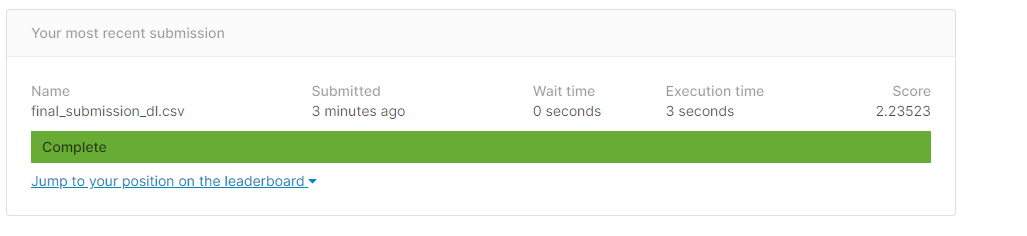

In [3]:
Image('Leaderboard.png')


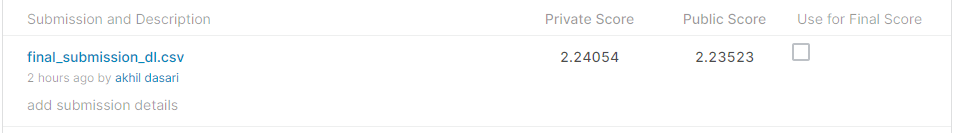

In [4]:
Image('Leaderboard_1.png')


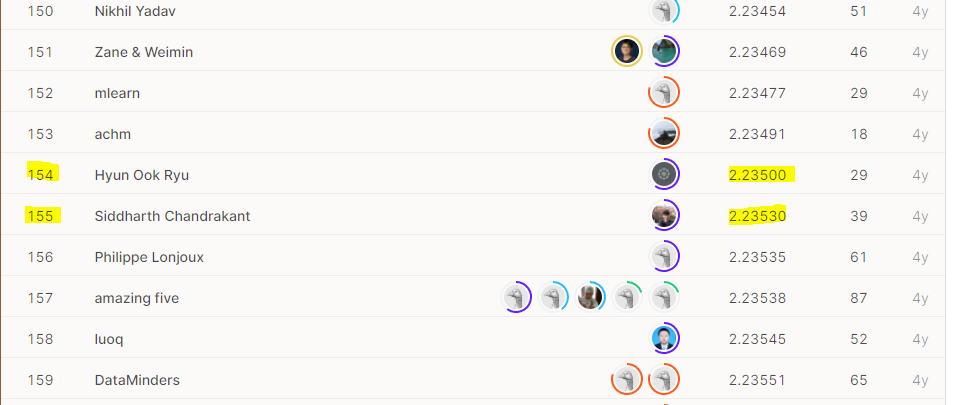

In [10]:
Image('Leaderboard_public.png')


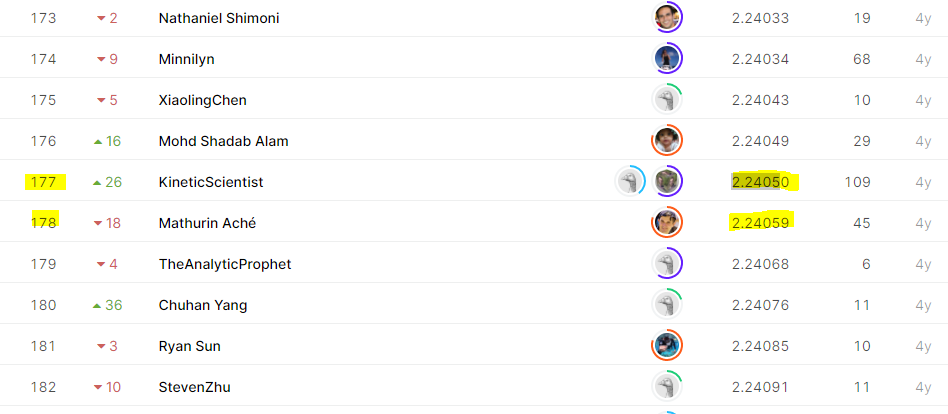

In [11]:
Image('Leaderboard_private.png')
